<div align="center">



# Deep Learning
## Electrical Engineering Department
### Homework 5: Variational Autoencoders and Vector Quantized Varitional Autoencoders
#### Ali Majlesi
ali.majlesi@sharif.edu
</div>


### Full Name : Mohammad Morsali
### Student Number : 400101956


This youtعbe video expalins VQ-VAEs : [videos link](https://www.youtube.com/watch?v=VZFVUrYcig0&ab_channel=AleksaGordi%C4%87-TheAIEpiphany)
## Introduction

Variational Auto Encoders (VAEs) can be thought of as what all but the last layer of a neural network is doing, namely feature extraction or seperating out the data. Thus given some data we can think of using a neural network for representation generation.

Recall that the goal of a generative model is to estimate the probability distribution of high dimensional data such as images, videos, audio or even text by learning the underlying structure in the data as well as the dependencies between the different elements of the data. This is very useful since we can then use this representation to generate new data with similar properties. This way we can also learn useful features from the data in an unsupervised fashion.

The VQ-VAE uses a discrete latent representation mostly because many important real-world objects are discrete. For example in images we might have categories like "Cat", "Car", etc. and it might not make sense to interpolate between these categories. Discrete representations are also easier to model since each category has a single value whereas if we had a continous latent space then we will need to normalize this density function and learn the dependencies between the different variables which could be very complex.


## Basic Idea

The overall architecture is summarized in the diagram below:

![](https://github.com/zalandoresearch/pytorch-vq-vae/blob/master/images/vq-vae.png?raw=1)

We start by defining a latent embedding space of dimension `[K, D]` where `K` are the number of embeddings and `D` is the dimensionality of each latent embeddng vector, i.e. $e_i \in \mathbb{R}^{D}$. The model is comprised of an encoder and a decoder. The encoder will map the input to a sequence of discrete latent variables, whereas the decoder will try to reconstruct the input from these latent sequences.

More preciesly, the model will take in batches of RGB images,  say $x$, each of size 32x32 for our example, and pass it through a ConvNet encoder producing some output $E(x)$, where we make sure the channels are the same as the dimensionality of the latent embedding vectors. To calculate the discrete latent variable we find the nearest embedding vector and output it's index.

The input to the decoder is the embedding vector corresponding to the index which is passed through the decoder to produce the reconstructed image.

Since the nearest neighbour lookup has no real gradient in the backward pass we simply pass the gradients from the decoder to the encoder  unaltered. The intuition is that since the output representation of the encoder and the input to the decoder share the same `D` channel dimensional space, the gradients contain useful information for how the encoder has to change its output to lower the reconstruction loss.

## Loss

The total loss is actually composed of three components

1. **reconstruction loss**: which optimizes the decoder and encoder
1. **codebook loss**: due to the fact that gradients bypass the embedding, we use a dictionary learning algorithm  which uses an $l_2$  error to move the embedding vectors $e_i$ towards the encoder output
1. **commitment loss**:  since the volume of the embedding space is dimensionless, it can grow arbirtarily if the embeddings $e_i$ do not train as fast as  the encoder parameters, and thus we add a commitment loss to make sure that the encoder commits to an embedding

In [1]:
!pip3 install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.6 MB/s eta 0:00:00


In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from six.moves import xrange
import umap
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data

In [4]:
training_data = datasets.CIFAR10(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

validation_data = datasets.CIFAR10(root="data", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

100%|██████████| 170M/170M [00:03<00:00, 48.6MB/s] 


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [5]:
data_variance = np.var(training_data.data / 255.0)
print(f"standard deviation :{np.sqrt(data_variance):.3f}")

standard deviation :0.252


## Vector Quantizer Layer

This layer takes a tensor to be quantized. The channel dimension will be used as the space in which to quantize. All other dimensions will be flattened and will be seen as different examples to quantize.

The output tensor will have the same shape as the input.

As an example for a `BCHW` tensor of shape `[16, 64, 32, 32]`, we will first convert it to an `BHWC` tensor of shape `[16, 32, 32, 64]` and then reshape it into `[16384, 64]` and all `16384` vectors of size `64`  will be quantized independently. In otherwords, the channels are used as the space in which to quantize. All other dimensions will be flattened and be seen as different examples to quantize, `16384` in this case.

In [8]:
class VectorQuantizerLayer(nn.Module):
    """
    A Vector Quantization layer that maps input vectors to the nearest embedding vectors
    from a learned codebook.
    """
    def __init__(self, num_codes, code_dim, commitment_weight):
        """
        Initializes the VectorQuantizerLayer.

        Args:
            num_codes (int): Number of embedding vectors in the codebook.
            code_dim (int): Dimensionality of each embedding vector.
            commitment_weight (float): Weight for the commitment loss term.
        """
        super(VectorQuantizerLayer, self).__init__()
        
        self.code_dim = code_dim
        self.num_codes = num_codes
        self.commitment_weight = commitment_weight

        # Initialize the embedding codebook with uniform distribution
        self.codebook = nn.Embedding(self.num_codes, self.code_dim)
        self.codebook.weight.data.uniform_(-1 / self.num_codes, 1 / self.num_codes)

    def forward(self, input_tensor):
        """
        Forward pass of the VectorQuantizerLayer.

        Args:
            input_tensor (torch.Tensor): Input tensor of shape (batch, channels, height, width).

        Returns:
            loss (torch.Tensor): Quantization loss.
            quantized_output (torch.Tensor): Quantized tensor with the same shape as input.
            perplexity (torch.Tensor): Perplexity of the codebook usage.
            one_hot_encodings (torch.Tensor): One-hot encodings of the closest embeddings.
        """
        # Rearrange input from (B, C, H, W) to (B, H, W, C)
        input_permuted = input_tensor.permute(0, 2, 3, 1).contiguous()
        input_shape = input_permuted.shape

        # Flatten the input to shape (B*H*W, C)
        flattened_input = input_permuted.view(-1, self.code_dim)

        # Compute squared L2 distance between input vectors and codebook embeddings
        # ||A - B||^2 = ||A||^2 + ||B||^2 - 2*A.B
        input_squared = torch.sum(flattened_input ** 2, dim=1, keepdim=True)  # (N, 1)
        codebook_squared = torch.sum(self.codebook.weight ** 2, dim=1)  # (num_codes,)
        distances = input_squared + codebook_squared - 2 * torch.matmul(flattened_input, self.codebook.weight.t())  # (N, num_codes)

        # Find the indices of the nearest embeddings
        nearest_indices = torch.argmin(distances, dim=1).unsqueeze(1)  # (N, 1)

        # Create one-hot encodings for the nearest embeddings
        one_hot_encodings = torch.zeros(flattened_input.size(0), self.num_codes, device=input_tensor.device)
        one_hot_encodings.scatter_(1, nearest_indices, 1)  # (N, num_codes)

        # Quantize the input by replacing each vector with its nearest embedding
        quantized = torch.matmul(one_hot_encodings, self.codebook.weight)  # (N, C)
        quantized = quantized.view(input_shape)  # (B, H, W, C)

        # Compute the quantization loss
        e_latent_loss = F.mse_loss(quantized.detach(), input_permuted)
        q_latent_loss = F.mse_loss(quantized, input_permuted.detach())
        quantization_loss = q_latent_loss + self.commitment_weight * e_latent_loss

        # Straight-through estimator to pass gradients
        quantized = input_permuted + (quantized - input_permuted).detach()

        # Calculate perplexity to measure codebook usage
        avg_probs = torch.mean(one_hot_encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # Rearrange quantized output back to (B, C, H, W)
        quantized_output = quantized.permute(0, 3, 1, 2).contiguous()

        return quantization_loss, quantized_output, perplexity, one_hot_encodings

# Testing the VectorQuantizerLayer
if __name__ == "__main__":
    # Define hyperparameters
    batch_size = 4
    channels = 3
    height = 16
    width = 16
    num_codes = 512
    code_dim = channels
    commitment_weight = 0.25
    num_iterations = 100  # Number of iterations for plotting

    # Initialize the VectorQuantizerLayer
    vector_quantizer = VectorQuantizerLayer(num_codes, code_dim, commitment_weight)

    # Lists to store loss and perplexity for plotting
    loss_history = []
    perplexity_history = []

    for iteration in range(num_iterations):
        # Generate random input tensor
        inputs = torch.randn(batch_size, channels, height, width)

        # Forward pass through the vector quantizer
        loss, quantized, perplexity, encodings = vector_quantizer(inputs)

        # Record loss and perplexity
        loss_history.append(loss.item())
        perplexity_history.append(perplexity.item())

            # # Print progress every 10 iterations
            # if (iteration + 1) % 10 == 0:
            #     print(f"Iteration {iteration + 1}/{num_iterations} - Loss: {loss.item():.4f}, Perplexity: {perplexity.item():.4f}")

    # Verify the output shape matches the input shape
    assert quantized.shape == inputs.shape, f"Expected shape {inputs.shape}, but got {quantized.shape}"
    print("Output shape is correct.")

    # # Plotting the loss and perplexity over iterations
    # fig, ax1 = plt.subplots(figsize=(10, 6))

    # color = 'tab:blue'
    # ax1.set_xlabel('Iteration')
    # ax1.set_ylabel('Loss', color=color)
    # ax1.plot(loss_history, color=color, label='Quantization Loss')
    # ax1.tick_params(axis='y', labelcolor=color)
    # ax1.legend(loc='upper left')

    # ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis

    # color = 'tab:red'
    # ax2.set_ylabel('Perplexity', color=color)  # We already handled the x-label with ax1
    # ax2.plot(perplexity_history, color=color, label='Perplexity')
    # ax2.tick_params(axis='y', labelcolor=color)
    # ax2.legend(loc='upper right')

    # plt.title('Vector Quantizer Training Metrics')
    # plt.tight_layout()
    # plt.show()


Output shape is correct.


We will also implement a slightly modified version  which will use exponential moving averages to update the embedding vectors instead of an auxillary loss. This has the advantage that the embedding updates are independent of the choice of optimizer for the encoder, decoder and other parts of the architecture. For most experiments the EMA version trains faster than the non-EMA version.

In [9]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost

        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()

        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)

            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)

            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

## Encoder & Decoder Architecture

The encoder and decoder architecture is based on a ResNet and is implemented below:

In [27]:


class Residual(nn.Module):
    def __init__(self, input_channels, hidden_channels, intermediate_channels):
        super(Residual, self).__init__()

        self.residual_sequence = nn.Sequential(
            nn.ReLU(inplace=False),  
            nn.Conv2d(
                in_channels=input_channels,
                out_channels=intermediate_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False
            ),
            nn.ReLU(inplace=False),  
            nn.Conv2d(
                in_channels=intermediate_channels,
                out_channels=hidden_channels,
                kernel_size=1,
                stride=1,
                bias=False
            )
        )

    def forward(self, input_tensor):
        residual_output = self.residual_sequence(input_tensor)
        return input_tensor + residual_output



class ResidualStack(nn.Module):
    def __init__(self, input_channels, hidden_channels, num_blocks, intermediate_channels):
        super(ResidualStack, self).__init__()

        self.num_blocks = num_blocks
        self.residual_blocks = nn.ModuleList([
            Residual(
                input_channels=input_channels if i == 0 else hidden_channels,
                hidden_channels=hidden_channels,
                intermediate_channels=intermediate_channels
            )
            for i in range(num_blocks)
        ])

    def forward(self, input_tensor):
        x = input_tensor
        for block in self.residual_blocks:
            x = block(x)
        return F.relu(x, inplace=False)  

class Encoder(nn.Module):
    """
    An Encoder module that progressively reduces the spatial dimensions of the input
    while increasing the number of feature channels. It utilizes convolutional layers
    followed by a Residual Stack for enhanced representational power.
    """
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        """
        Initializes the Encoder.

        Args:
            in_channels (int): Number of channels in the input tensor.
            num_hiddens (int): Number of channels produced by the convolutional layers.
            num_residual_layers (int): Number of Residual Blocks in the Residual Stack.
            num_residual_hiddens (int): Number of hidden channels within each Residual Block.
        """
        super(Encoder, self).__init__()

        # First Convolutional Layer

        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=num_hiddens // 2,
            kernel_size=4,
            stride=2,
            padding=1
        )

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(
            in_channels=num_hiddens // 2,
            out_channels=num_hiddens,
            kernel_size=4,
            stride=2,
            padding=1
        )

        # Third Convolutional Layer
        self.conv3 = nn.Conv2d(
            in_channels=num_hiddens,
            out_channels=num_hiddens,
            kernel_size=3,
            stride=1,
            padding=1
        )

        # Residual Stack for enhanced feature representation
        self.residual_stack = ResidualStack(
            input_channels=num_hiddens,
            hidden_channels=num_hiddens,
            num_blocks=num_residual_layers,
            intermediate_channels=num_residual_hiddens
        )

    def forward(self, input_tensor):
        """
        Defines the forward pass of the Encoder.

        Args:
            input_tensor (torch.Tensor): Input tensor of shape (B, C, H, W).

        Returns:
            torch.Tensor: Output tensor after encoding.
        """
        # Pass through the first convolutional layer followed by ReLU activation
        x = F.relu(self.conv1(input_tensor))

        # Pass through the second convolutional layer followed by ReLU activation
        x = F.relu(self.conv2(x))

        # Pass through the third convolutional layer (no activation)
        x = self.conv3(x)

        # Pass through the Residual Stack
        x = self.residual_stack(x)

        return x


class Decoder(nn.Module):
    """
    A Decoder module that reconstructs the input data by progressively increasing
    the spatial dimensions while decreasing the number of feature channels. It utilizes
    convolutional layers followed by a Residual Stack and transposed convolutional layers
    (deconvolutions) for upsampling.
    """
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        """
        Initializes the Decoder.

        Args:
            in_channels (int): Number of channels in the input tensor.
            num_hiddens (int): Number of channels used in the convolutional layers.
            num_residual_layers (int): Number of Residual Blocks in the Residual Stack.
            num_residual_hiddens (int): Number of hidden channels within each Residual Block.
        """
        super(Decoder, self).__init__()

        # First Convolutional Layer
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=num_hiddens,
            kernel_size=3,
            stride=1,
            padding=1
        )

        # Residual Stack to refine the representation
        self.residual_stack = ResidualStack(
            input_channels=num_hiddens,
            hidden_channels=num_hiddens,
            num_blocks=num_residual_layers,
            intermediate_channels=num_residual_hiddens
        )

        # First Transposed Convolutional Layer (Deconvolution)
        self.deconv1 = nn.ConvTranspose2d(
            in_channels=num_hiddens,
            out_channels=num_hiddens // 2,
            kernel_size=4,
            stride=2,
            padding=1
        )

        # Second Transposed Convolutional Layer (Deconvolution)
  
        self.deconv2 = nn.ConvTranspose2d(
            in_channels=num_hiddens // 2,
            out_channels=3,  # For RGB images
            kernel_size=4,
            stride=2,
            padding=1
        )

    def forward(self, x):
        """
        Defines the forward pass of the Decoder.

        Args:
            x (torch.Tensor): Input tensor of shape (B, C, H, W).

        Returns:
            torch.Tensor: Reconstructed tensor after decoding.
        """
        # Pass through the initial convolutional layer followed by ReLU activation
        x = F.relu(self.conv1(x))

        # Pass through the Residual Stack
        x = self.residual_stack(x)

        # Pass through the first transposed convolutional layer followed by ReLU activation
        x = F.relu(self.deconv1(x))

        # Pass through the second transposed convolutional layer to obtain the final reconstructed image
        reconstructed = self.deconv2(x)

        return reconstructed


## Train

We use the hyperparameters from the author's code:

In [28]:
batch_size = 256
num_training_updates = 15000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

In [29]:
training_loader = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             pin_memory=True)

In [30]:
validation_loader = DataLoader(validation_data,
                               batch_size=32,
                               shuffle=True,
                               pin_memory=True)

In [31]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()

        self._encoder = Encoder(3, num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,
                                      out_channels=embedding_dim,
                                      kernel_size=1,
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim,
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

In [32]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, decay).to(device)

In [33]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [34]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

for i in xrange(num_training_updates):
    (data, _) = next(iter(training_loader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data) / data_variance

    # TODO: Calculate Total loss which is th sum of recon_error and vq_loss
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 100 == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

100 iterations
recon_error: 0.996
perplexity: 1.000

200 iterations
recon_error: 0.981
perplexity: 1.000

300 iterations
recon_error: 0.981
perplexity: 1.000

400 iterations
recon_error: 0.983
perplexity: 1.000

500 iterations
recon_error: 1.009
perplexity: 1.038

600 iterations
recon_error: 0.761
perplexity: 1.533

700 iterations
recon_error: 0.357
perplexity: 2.637

800 iterations
recon_error: 0.277
perplexity: 4.151

900 iterations
recon_error: 0.231
perplexity: 6.843

1000 iterations
recon_error: 0.213
perplexity: 11.067

1100 iterations
recon_error: 0.187
perplexity: 14.605

1200 iterations
recon_error: 0.167
perplexity: 19.119

1300 iterations
recon_error: 0.158
perplexity: 21.752

1400 iterations
recon_error: 0.148
perplexity: 24.075

1500 iterations
recon_error: 0.137
perplexity: 27.008

1600 iterations
recon_error: 0.130
perplexity: 29.757

1700 iterations
recon_error: 0.125
perplexity: 33.207

1800 iterations
recon_error: 0.119
perplexity: 37.147

1900 iterations
recon_error:

## Plot Loss

In [35]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

Text(0.5, 0, 'iteration')

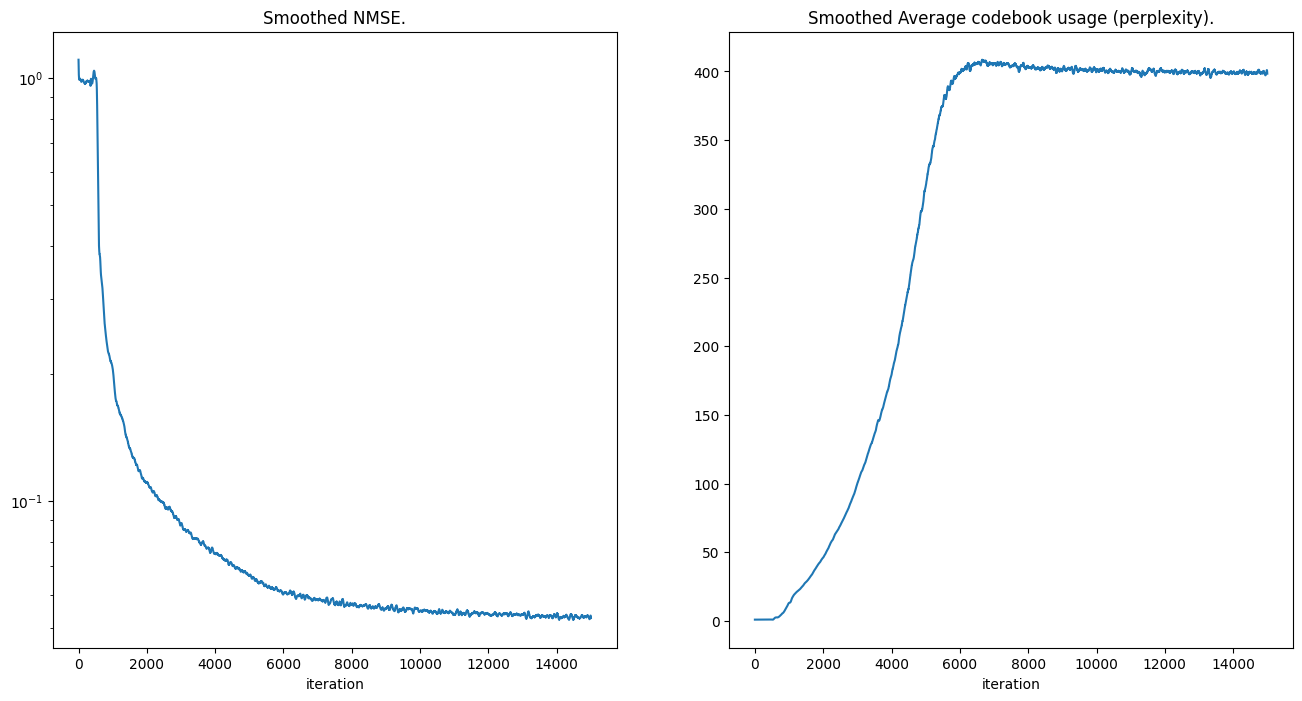

In [36]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

## View Reconstructions

In [37]:
model.eval()

(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

In [38]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

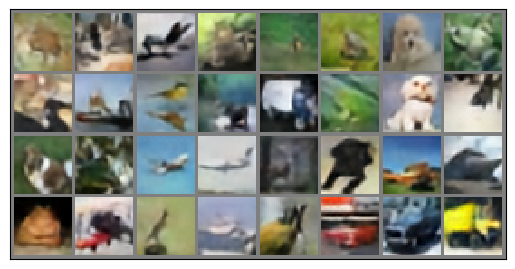

In [39]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

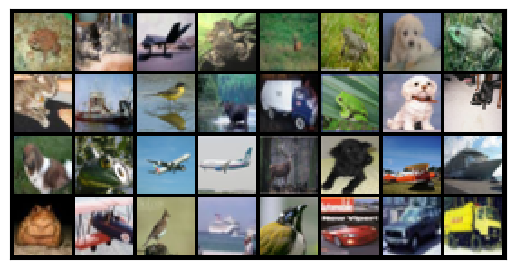

In [40]:
show(make_grid(valid_originals.cpu()+0.5))

## View Embedding

In [52]:
proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model._vq_vae._embedding.weight.data.cpu())

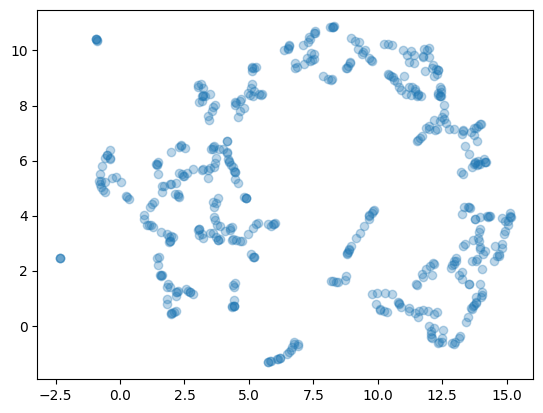

In [53]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)

## **Questions**

---

### **(a)  VQ-VAE Cost Function**

The **Vector Quantized Variational Autoencoder (VQ-VAE)** utilizes a cost function \( L \) that comprises three essential components. Each component plays a pivotal role in enabling the model to learn meaningful and discrete latent representations effectively. Below is an in-depth exploration of each term:

1. **Reconstruction Loss (\( \log(p(x \mid z_q(x))) \))**
   - **Objective**: Assesses how accurately the model can reconstruct the input data from the quantized latent representation.
   - **Implementation**:
     - Commonly implemented using **Negative Log-Likelihood (NLL)** or **Mean Squared Error (MSE)**.
     - Quantifies the difference between the original input \( x \) and its reconstruction derived from the quantized latent vector \( z_q(x) \).
   - **Implications**:
     - A lower reconstruction loss indicates that the decoder effectively rebuilds the input from the quantized latent space, ensuring that critical information is retained.

2. **Codebook Loss (\( \|z_e(x)\text{.detach()} - e\|_2^2 \))**
   - **Objective**: Aligns the continuous output of the encoder with the discrete embedding vectors in the codebook.
   - **Mechanism**:
     - The encoder generates \( z_e(x) \), which is **detached** from the computational graph to prevent gradients from flowing back through it.
     - Measures the Euclidean distance between this detached encoder output and the selected codebook vector \( e \).
   - **Functionality**:
     - Adjusts the codebook vectors \( e \) to better represent the encoder's outputs, fostering a more accurate and representative discrete latent space.

3. **Commitment Loss (\( \beta \|z_e(x) - e\text{.detach()}\|_2^2 \))**
   - **Objective**: Ensures that the encoder consistently commits to specific codebook embeddings, promoting stability.
   - **Details**:
     - The **detach()** operation allows gradients to flow only through \( z_e(x) \), excluding the codebook vectors \( e \) from receiving updates from this term.
     - The hyperparameter \( \beta \) governs the weight of this commitment, balancing it against the reconstruction and codebook losses.
   - **Outcome**:
     - Prevents the encoder from producing outputs that deviate from the discrete embedding space, enhancing the stability and reliability of the latent representations.

**Aggregated Cost Function**:
\[
L = \log(p(x \mid z_q(x))) + \|z_e(x)\text{.detach()} - e\|_2^2 + \beta \|z_e(x) - e\text{.detach()}\|_2^2
\]
- **Reconstruction Loss**: Ensures accurate data reconstruction.
- **Codebook Loss**: Refines embedding vectors to align with encoder outputs.
- **Commitment Loss**: Maintains encoder outputs within the discrete embedding space.

Together, these components facilitate VQ-VAE in learning a structured and discrete latent representation that is both expressive and effective for data reconstruction.

---

### **(b) Mechanism for Updating Embeddings in the Codebook**

Updating the **codebook embeddings** is fundamental for VQ-VAE to accurately capture the underlying data distribution. This process involves selecting appropriate embeddings and adjusting them to better represent the encoded data. The following steps elucidate this mechanism:

1. **Selection of the Nearest Embedding (Nearest Neighbor Selection)**
   - **Process**:
     - For each encoder output \( z_e(x) \), the model identifies the closest embedding vector \( e_k \) from the codebook based on Euclidean distance.
   - **Mathematical Representation**:
     \[
     q(z = e_k \mid x) =
     \begin{cases}
     1 & \text{if } k = \arg \min_j \|z_e(x) - e_j\|_2 \\
     0 & \text{otherwise}
     \end{cases}
     \]
   - **Explanation**:
     - This hard assignment ensures that each encoder output is mapped to the single most similar embedding vector, enforcing a discrete latent space.

2. **Updating the Selected Embedding (Exponential Moving Averages)**
   - **Objective**: Gradually adjust the selected embedding to better align with the encoder outputs over time.
   - **Update Rule**:
     \[
     e_k \gets \text{decay} \times e_k + (1 - \text{decay}) \times z_e(x)
     \]
   - **Mechanism**:
     - **Decay Factor**: Determines the influence of previous updates versus new information. A typical value might be close to 1 (e.g., 0.99), ensuring smooth and incremental updates.
     - **Effect**: Ensures that the embedding \( e_k \) slowly converges towards the average of the encoder outputs that are mapped to it, capturing prevalent patterns in the data.

3. **Consequences of the Update Mechanism**
   - **Adaptive Codebook**:
     - Over successive iterations, the embeddings evolve to represent the most common features in the data, effectively clustering similar encoder outputs.
   - **Stability**:
     - Embeddings not frequently selected remain largely unchanged, preventing the codebook from fluctuating unpredictably.
   - **Representation Quality**:
     - As embeddings converge towards meaningful prototypes, the overall quality of the latent space improves, facilitating better reconstructions and more efficient data encoding.

**Intuitive Understanding of Codebook Vectors**:
- **Cluster Centers**: Each embedding vector \( e_k \) acts as a centroid for a cluster of similar encoder outputs, encapsulating shared features or patterns.
- **Data Prototyping**: In image datasets, for instance, embeddings might represent recurring textures, color schemes, or structural elements, enabling the model to synthesize diverse inputs from a finite set of prototypes.
- **Structured Latent Space**: By enforcing a discrete set of embeddings, VQ-VAE organizes the latent space into distinct regions, each corresponding to specific data characteristics, which aids in both interpretability and generative capabilities.

**Conclusion**:
The codebook in VQ-VAE serves as a dynamic repository of latent prototypes that adapt to the data distribution through a disciplined update mechanism. By iteratively refining these embeddings using nearest neighbor assignments and exponential moving averages, the model ensures that the latent space remains both representative and efficient, ultimately enhancing the quality of data reconstruction and the robustness of learned representations.

---
